<a href="https://colab.research.google.com/github/jaiyue/Movie-Data-Analysis/blob/main/Movie_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Remove the movie dataset to ensure the next download succeeds

In [13]:
!rm -r the-movies-dataset

import every tool

In [14]:
!pip install opendatasets
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ast, json

upload kaggle.json file to download dataset

In [15]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"hailingcai","key":"3581232c04d8591ebaeedf74bd3de296"}'}

In [16]:
od.download('https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset')

Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset


100%|██████████| 228M/228M [00:00<00:00, 477MB/s]


In [17]:
!ls /content/the-movies-dataset

credits.csv   links.csv        movies_metadata.csv  ratings_small.csv
keywords.csv  links_small.csv  ratings.csv


In [18]:
movies = pd.read_csv('/content/the-movies-dataset/movies_metadata.csv', low_memory=False)
ratings = pd.read_csv('/content/the-movies-dataset/ratings_small.csv')
credits = pd.read_csv('/content/the-movies-dataset/credits.csv')
keywords = pd.read_csv('/content/the-movies-dataset/keywords.csv')

check data structue and the top 5 row

In [19]:
print(movies.head())
print(movies.info())
print(ratings.head())
print(credits.head())
print(keywords.head())

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

 Clean dat: delete useless column

In [20]:
movies = movies.drop(['homepage', 'poster_path', 'tagline'], axis=1)

Separate all released movies from other movies

In [21]:
print(movies['status'].unique())

['Released' nan 'Rumored' 'Post Production' 'In Production' 'Planned'
 'Canceled']


In [22]:
released_movies = movies[movies['status'] == 'Released'].copy()
other_movies = movies[movies['status'] != 'Released'].copy()

print("Released movies:", released_movies.shape)
print("Other movies:", other_movies.shape)

Released movies: (45014, 21)
Other movies: (452, 21)


Basic Statistics:
1.  How has the number of movies released each year changed?


* Convert release_date to date format (set invalid values to NaT)
* Delete invalid dates
* Extract release_year
* Number of movies by year
* Visualization









Removed 78 rows with invalid release_date.
                         title  release_year
0                    Toy Story          1995
1                      Jumanji          1995
2             Grumpier Old Men          1995
3            Waiting to Exhale          1995
4  Father of the Bride Part II          1995
release_year
1874    1
1878    1
1883    1
1887    1
1888    2
dtype: int64
Movies year range: 1874 - 2017


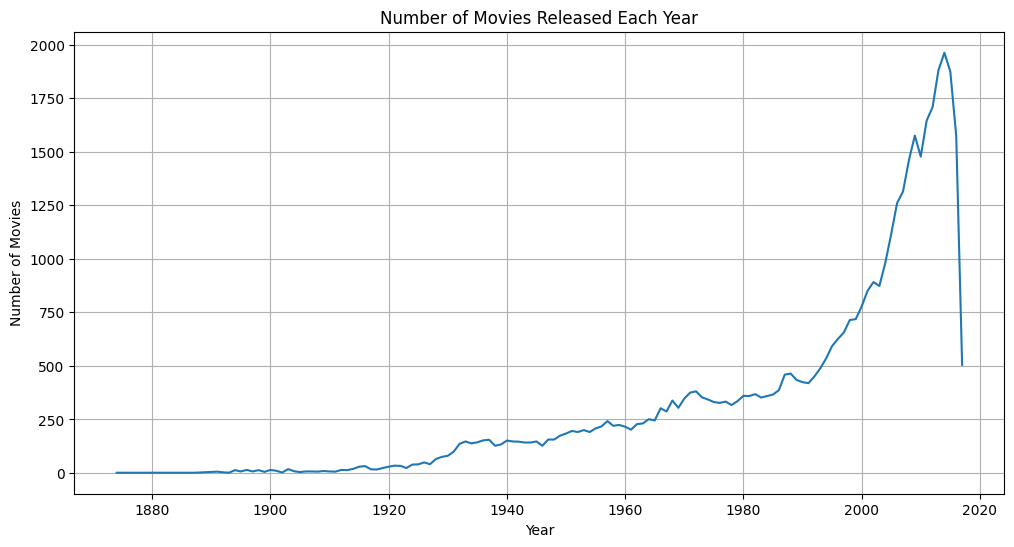

In [23]:
# Convert release_date to date format (invalid formats will become NaT)
released_movies['release_date'] = pd.to_datetime(released_movies['release_date'], errors='coerce')

# check how many dates are invaild
original_count = len(released_movies)
released_movies = released_movies.dropna(subset=['release_date'])
cleaned_count = len(released_movies)
print(f"Removed {original_count - cleaned_count} rows with invalid release_date.")

# Extract year
released_movies['release_year'] = released_movies['release_date'].dt.year
print(released_movies[['title', 'release_year']].head())

# Number of movies by year
movies_per_year = released_movies.groupby('release_year').size()
print(movies_per_year.head())
min_year = released_movies['release_year'].min()
max_year = released_movies['release_year'].max()
print(f"Movies year range: {min_year} - {max_year}")

# Draw line graph
plt.figure(figsize=(12,6))
movies_per_year.plot(kind='line')
plt.title("Number of Movies Released Each Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.grid(True)
plt.show()

2.  What is the average runtime for movies in different genres?

In [24]:
released_movies_runtime = movies[movies['status'] == 'Released'].copy()
released_movies['runtime'] = pd.to_numeric(released_movies['runtime'], errors='coerce')
# Clean up movies with illegal runtime
released_movies = released_movies[released_movies['runtime'] > 0]

# Define the function and convert genres into strings
def getname(x):
    a = []
    for i in x:
        a.append(i['name'])
    return ','.join(a)

# String → Python object, extract "name"
released_movies['genres'] = released_movies['genres'].apply(ast.literal_eval)
released_movies['genres'] = released_movies['genres'].apply(getname)

# Split the type string of each movie into a list and expand it
released_movies['genre'] = released_movies['genres'].str.split(',')
released_movies = released_movies.explode('genre')

# Remove empty strings
released_movies['genre'] = released_movies['genre'].str.strip()
released_movies = released_movies[released_movies['genre'] != '']

num_genres = released_movies['genre'].nunique()
print(f"Number of unique genres: {num_genres}")

# Calculate average runtiime by 'genre'
avg_runtime = released_movies.groupby('genre')['runtime'].mean()
print("Average runtime (minutes) by genre:")
print(avg_runtime)


Number of unique genres: 20
Average runtime (minutes) by genre:
genre
Action             102.697884
Adventure          103.056124
Animation           65.155638
Comedy              94.425949
Crime              101.534679
Documentary         90.373623
Drama              105.131349
Family              89.278297
Fantasy             95.215678
Foreign            105.001313
History            126.285819
Horror              91.273405
Music              100.898653
Mystery             99.925342
Romance            104.336900
Science Fiction     95.454209
TV Movie            96.936200
Thriller           100.521768
War                114.006923
Western             98.844727
Name: runtime, dtype: float64


Financial Analysis

1.   What are the revenue differences between high-budget and low-budget movies?


2.   What objective factors influence movie revenue?
